# Crawling Food Product Data from German Retailer Budni

**Goal**: extract details of food products through Budni's API.

Relevant API endpoints:

- `POST https://www.budni.de/api/content/articles/v2/search` - list/search products.
- `GET  https://www.budni.de/api/content/articles/v3/{articleId}?branchId={branchId}` - get product details.
- `GET  https://www.budni.de/api/infra/branches/{branchId}` - get Budni store details.

Important: the API requests must include the ID of a specific Budni store (`branchId`), e.g. `412101` for Bergstr. 16, 20095 Hamburg (Europa Passage).

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Search API — Get List of Food Products

Goal: Get a list of all food products offered by Budni.

The most suitable API endpoint is `https://www.budni.de/api/content/articles/v2/search`. It expects a `POST` request with search parameters in the payload. The result set will be paginated.
- Request 200 results (the maximum allowed by the API)
- Filter on the category 'Genuss' to return only food products.

In [2]:
search_url = "https://www.budni.de/api/content/articles/v2/search"

# result items are limited to 200
req_data = {
  "branchId": 412101,
  "query": "*",
  "page": 1,
  "hitsPerPage": 200,
  "filters": [
    {
      "name": "category",
      "values": [
        {
          "value": "Genuss",
          "type": "or",
          "exclude": False
        }
      ]
    }
  ],
  "sortItems": [],
  "identifier": "web"
}

In [3]:
try:
    response = requests.post(search_url, json=req_data)
    response.raise_for_status()
    
    result = response.json()
    print(f"results parts: {list(result.keys())}")
    print(f"total results: {result['totalHits']}")
    print(f"results items: {len(result['hits'])}")
    print(f"result page: {result['paging']['currentPage']}")
    print(f"total pages: {result['paging']['pageCount']}")
    
except requests.exceptions.RequestException as req_err:
    print(f"Request failed: {req_err}")
except HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
except JSONDecodeError:
    print("Cannot parse json response")

results parts: ['searchParams', 'totalHits', 'paging', 'hits', 'facets', 'sortItems']
total results: 14787
results items: 200
result page: 1
total pages: 74


## Results Details

In [4]:
print(json.dumps(result['hits'][0], indent=4, ensure_ascii=False))

{
    "id": 2854279009,
    "masterValues": {
        "ean": 4039057411558,
        "brand": "BIO GOURMET",
        "name": "Biog.Kürbisk.Öl kaltg.100ml",
        "isDiscountable": true,
        "hasBabyClubBonus": false,
        "category": {
            "level1": "Genuss",
            "level2": "Kochhilfen & Gewürze"
        },
        "labels": [],
        "description": "Biogourmet Kürbiskernöl geröstet und kaltgepresst aus Österreich 100ml",
        "tradeDescription": "Speiseöle",
        "searchAttributes": [
            "Kochhilfen & Gewürze",
            "Öle & Essig",
            "Öle",
            "Speiseöle",
            "BIO GOURMET"
        ],
        "price": 679,
        "images": [
            "https://budni-static.live.cellular.de/images/edeka/articles/DV019_4039057411558_VOR.png"
        ],
        "displayName": "Kürbiskernöl",
        "base": {
            "price": 6790,
            "contents": "1",
            "baseUnit": "L"
        },
        "contents": "0.1",


In [13]:
data = [{'id': x['id'],} | x['masterValues'] for x in result['hits']]
products_df = pd.DataFrame.from_records(data)
print(f"Result has {products_df.shape[0]} items")

Result has 200 items


In [6]:
products_df.drop(columns=['isDiscountable', 'hasBabyClubBonus', 'labels', 'bonusPoints'])

,id,ean,brand,name,category,description,tradeDescription,searchAttributes,price,images,...,sustainable,isBiocid,qualityBrand,priceGroup,depositPrice,priceOffer,referencePrice,herstellerUvp,discount,strikePrice
0,2854279009,4039057411558,BIO GOURMET,Biog.Kürbisk.Öl kaltg.100ml,"{'level1': 'Genuss', 'level2': 'Kochhilfen & G...",Biogourmet Kürbiskernöl geröstet und kaltgepre...,Speiseöle,"[Kochhilfen & Gewürze, Öle & Essig, Öle, Speis...",679,[https://budni-static.live.cellular.de/images/...,...,"{'attributes': ['SPECIES_DIVERSITY', 'CLIMATE'...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2969148007,4104420030220,ALNATURA,"Bio Alna.Italie.Olivenöl 0,5l","{'level1': 'Genuss', 'level2': 'Kochhilfen & G...",Bio Alnatura Italienisches Olivenöl (Olio Extr...,Öl,"[Kochhilfen & Gewürze, Öle & Essig, Öle, Öl, V...",899,[https://budni-static.live.cellular.de/images/...,...,"{'attributes': ['SPECIES_DIVERSITY', 'CLIMATE'...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2967808006,4104420028708,ALNATURA,Bio Alna.Ghee 180g,"{'level1': 'Genuss', 'level2': 'Kochhilfen & G...",Bio Alnatura Ghee 180g,Fette,"[Kochhilfen & Gewürze, Öle & Essig, Öle, Fette...",499,[https://budni-static.live.cellular.de/images/...,...,"{'attributes': ['SPECIES_DIVERSITY', 'CLIMATE'...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2969406000,4104420030961,ALNATURA,"Bio Alna.Condimento Bianco0,5l","{'level1': 'Genuss', 'level2': 'Kochhilfen & G...","Bio Alnatura Condimento Bianco 0,5l",Essig,"[Kochhilfen & Gewürze, Öle & Essig, Balsamico+...",299,[https://budni-static.live.cellular.de/images/...,...,"{'attributes': ['SPECIES_DIVERSITY', 'CLIMATE'...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2969150000,4104420031050,ALNATURA,"Bio Alna.Olivenöl 0,5l","{'level1': 'Genuss', 'level2': 'Kochhilfen & G...","Bio Alnatura Olivenöl 0,5l",Öl,"[Kochhilfen & Gewürze, Öle & Essig, Öle, Öl, V...",399,[https://budni-static.live.cellular.de/images/...,...,"{'attributes': ['SPECIES_DIVERSITY', 'CLIMATE'...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,120959006,40084060,FERRERO,Yogurette Erdbeere 100g,"{'level1': 'Genuss', 'level2': 'Süßware Snack ...",Yogurette Erdbeere 100g,Schokoriegel,"[Süßware+Snack konv., Schokolade, Schokoriegel...",139,[https://budni-static.live.cellular.de/images/...,...,"{'attributes': [], 'participates': False}",False,NaN,73032073,NaN,NaN,NaN,NaN,NaN,NaN
196,121385004,4017100101007,BAHLSEN,Leibniz Minis Butterkekse 150g,"{'level1': 'Genuss', 'level2': 'Süßware Snack ...",Leibniz Minis Butterkekse 150g,Butterkekse,"[Süßware+Snack konv., Kekse, Butterkekse, BAHL...",159,[https://budni-static.live.cellular.de/images/...,...,"{'attributes': [], 'participates': False}",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,120960006,40084176,FERRERO,"kinder Country 23,5g","{'level1': 'Genuss', 'level2': 'Kassenzone'}","Ferrero kinder Country 23,5g",Schokoriegel,"[Kassenzone, Kassenartikel, Schokoriegel, FERR...",39,[https://budni-static.live.cellular.de/images/...,...,"{'attributes': [], 'participates': False}",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,120975008,4008400221021,FERRERO,kinder Riegel 10x21g,"{'level1': 'Genuss', 'level2': 'Süßware Snack ...",Ferrero kinder Riegel 10x21g,Schokoriegel,"[Süßware+Snack konv., Riegel, Schokoriegel, FE...",259,[https://budni-static.live.cellular.de/images/...,...,"{'attributes': [], 'participates': False}",False,NaN,73031536,NaN,NaN,NaN,NaN,NaN,NaN


## Basic Data Analysis

In [7]:
products_df.brand.value_counts()

brand
ALNATURA           31
FERRERO            18
LINDT              14
RITTER SPORT       10
LANGNESE           10
                   ..
RIEGELEIN           1
ZETTI               1
SENSEO              1
ALBERTO             1
BAD HEILBRUNNER     1
Name: count, Length: 68, dtype: int64

## Show Product Images

In [8]:
from PIL import Image
import urllib

  0%|          | 0/8 [00:00<?, ?it/s]

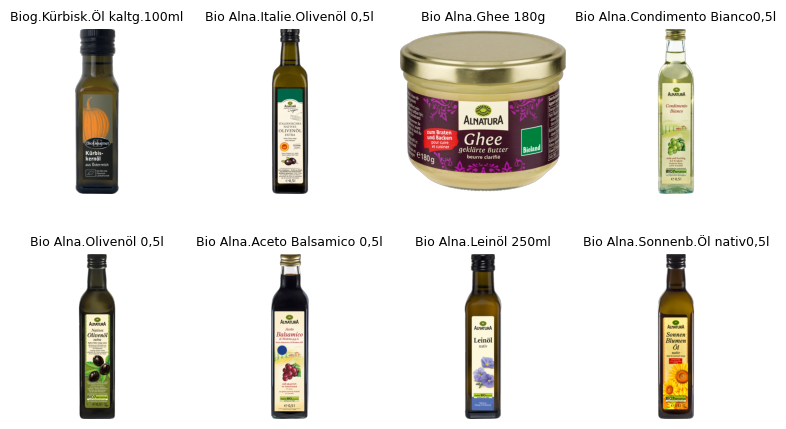

In [9]:
rows = 2; cols = 4

fig, ax = plt.subplots(rows, cols, figsize=(8, 5))
axs = ax.flatten()

for i, prod in tqdm(list(products_df.head(rows * cols).iterrows())):
    
    # load image and paste png image on white background
    url_im = Image.open(urllib.request.urlopen(prod.images[0]))
    im = Image.new("RGBA", url_im.size, "WHITE")
    im.paste(url_im)
    
    ax = axs[i]
    ax.imshow(im)
    ax.set_title(prod['name'], size=9)
    ax.axis('off')

fig.tight_layout(pad=2)

## Fetch Article Data

The article data does not add much to what is already returned as search response.

The most notable differences are

- more categories
- Edeka data

In [10]:
article_url_base = "https://www.budni.de/api/content/articles/v3/"
article_id = products_df.id[0]

try:
    res = requests.get(f"{article_url_base}{article_id}", params={"branchId": 412101})
except requests.exceptions.RequestException as e:
    print(e)

In [11]:
print(json.dumps(res.json(), indent=4, ensure_ascii=False))

{
    "isDiscountable": true,
    "hasBabyClubBonus": false,
    "price": 679,
    "base": {
        "baseUnit": "L",
        "price": 6790,
        "contents": 1
    },
    "bonusPoints": 340,
    "name": "Biog.Kürbisk.Öl kaltg.100ml",
    "displayName": "Kürbiskernöl",
    "tradeDescription": "Speiseöle",
    "sortCategories": {
        "level1": {
            "id": "04",
            "name": "Genuss"
        },
        "level2": {
            "id": "0413",
            "name": "Kochhilfen & Gewürze"
        },
        "level3": {
            "id": "041301",
            "name": "Öle & Essig"
        },
        "level4": {
            "id": "04130101",
            "name": "Öle"
        }
    },
    "suggestions": {
        "suggest": {
            "input": [
                "Kochhilfen & Gewürze",
                "Öle & Essig",
                "Öle",
                "Speiseöle"
            ]
        },
        "brandSuggest": {
            "input": [
                "BIO GOURMET"
      